In [1]:
!pip install wandb pyyaml opencv-python;

In [2]:
import os
import yaml
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import wandb
from wandb.integration.keras import WandbCallback

2025-05-04 13:46:55.466092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-04 13:46:55.484873: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-04 13:46:55.490632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 13:46:55.506676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-04 13:46:56.329106: W tensorflow/compiler/tf2

In [3]:
wandb.login(key="017feefe0af6702cda76aab121ec71cf3a362fec")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc
wandb: Currently logged in as: samutheman (rueedi-tobias-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
dataset_yaml = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/data.yaml"
images_trainset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/train"
labels_trainset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/train"
images_valset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/val"
labels_valset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/val"
images_testset = False#"/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/test"
labels_testset = False#"/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/test"


In [5]:
with open(dataset_yaml, "r") as f:
    config = yaml.safe_load(f)


In [6]:
# --- Parameters ---
IMG_SIZE = 256
GRID_SIZE = 32
CELLS = GRID_SIZE * GRID_SIZE
NUM_BOXES = 1  # one box per grid cell
BBOX_ATTRS = 4  # x, y, w, h
OUTPUT_SHAPE = (GRID_SIZE, GRID_SIZE, NUM_BOXES * (BBOX_ATTRS + 1))

In [7]:
def build_yolo_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)  # 64x64
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)  # 32x32
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)  # 16x16
    x = layers.Conv2D(OUTPUT_SHAPE[-1], 1, activation='sigmoid')(x)  # final layer
    x = layers.Reshape(OUTPUT_SHAPE)(x)  # shape: (4, 4, B*(5+C))
    return tf.keras.Model(inputs, x)


In [8]:
def yolo_loss(y_true, y_pred):
    # Mean squared error over box + class + objectness
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

In [9]:
def load_yolo_dataset(image_dir, label_dir, img_size=IMG_SIZE):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
    x_data, y_data = [], []

    for img_path in image_paths:
        filename = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_dir, f"{filename}.txt")

        # Load image
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        x_data.append(img)

        # Create empty label grid
        label = np.zeros(OUTPUT_SHAPE, dtype=np.float32)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()
            for line in lines:
                class_id, x, y, w, h = map(float, line.strip().split())
                grid_x = int(x * GRID_SIZE)
                grid_y = int(y * GRID_SIZE)
                if grid_x >= GRID_SIZE or grid_y >= GRID_SIZE:
                    continue

                # relative x,y,w,h within the cell
                cell_x = x * GRID_SIZE - grid_x
                cell_y = y * GRID_SIZE - grid_y
                label[grid_y, grid_x, :5] = [cell_x, cell_y, w, h, 1.0]
                label[grid_y, grid_x, 4 + int(class_id)] = 1.0  # class one-hot

        y_data.append(label)

    return np.array(x_data, dtype=np.float32), np.array(y_data, dtype=np.float32)


In [10]:
x_train, y_train = load_yolo_dataset(images_trainset, labels_trainset)
x_val, y_val     = load_yolo_dataset(images_valset, labels_valset)
if images_testset:
    x_test, y_test = load_yolo_dataset(images_testset , labels_testset)

In [11]:
wandb.init(project="Own CNN", name="Detector", config=config)

In [12]:
print("x_train type:", type(x_train))
print("x_train shape:", getattr(x_train, 'shape', 'No shape'))
print("First element type:", type(x_train[0]))

x_train type: <class 'numpy.ndarray'>
x_train shape: (10858, 256, 256, 3)
First element type: <class 'numpy.ndarray'>


In [13]:
model = build_yolo_model()
model.compile(optimizer='adam', loss=yolo_loss)

model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=[WandbCallback(save_graph = False, save_model = False)]
)
if images_testset:
    loss = model.evaluate(x_test, y_test)
    print("Test Loss:", loss)

2025-05-04 13:47:59.952696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:86:00.0, compute capability: 8.6
wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
2025-05-04 13:48:14.432380: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8539078656 exceeds 10% of free system memory.
2025-05-04 13:48:20.088631: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8539078656 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1746366505.118276   51427 service.cc:146] XLA service 0x7fc17400a230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746366505.118324   51427 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2025-05-04 13:48:25.689154: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-04 13:48:26.229622: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-05-04 13:48:32.167232: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  3/679 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 0.2288   

I0000 00:00:1746366514.049254   51427 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


679/679 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - loss: 0.0114 - val_loss: 0.0025
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 4/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 10/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - loss: 0.0024 - val_loss: 0.0025


In [14]:
import matplotlib.pyplot as plt
import cv2

def draw_boxes(image, label_grid, pred_grid, conf_thresh=0.5):
    img = (image * 255).astype(np.uint8).copy()
    h, w, _ = img.shape
    cell_h, cell_w = h // GRID_SIZE, w // GRID_SIZE

    # True labels
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            obj = label_grid[gy, gx, 4]
            if obj > 0.5:
                x, y, bw, bh = label_grid[gy, gx, :4]
                cx = int((gx + x) * cell_w)
                cy = int((gy + y) * cell_h)
                bw = int(bw * w)
                bh = int(bh * h)
                cv2.rectangle(img, (cx - bw//2, cy - bh//2), (cx + bw//2, cy + bh//2), (0, 255, 0), 2)

    # Predicted boxes
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            obj = pred_grid[gy, gx, 4]
            if obj > conf_thresh:
                x, y, bw, bh = pred_grid[gy, gx, :4]
                cx = int((gx + x) * cell_w)
                cy = int((gy + y) * cell_h)
                bw = int(bw * w)
                bh = int(bh * h)
                cv2.rectangle(img, (cx - bw//2, cy - bh//2), (cx + bw//2, cy + bh//2), (0, 0, 255), 2)

    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


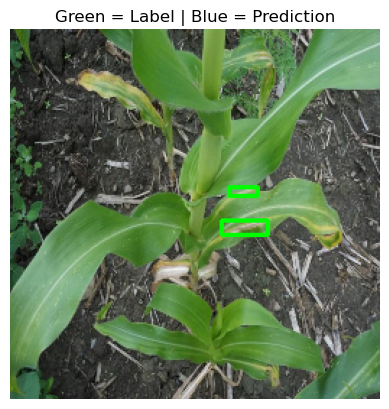

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


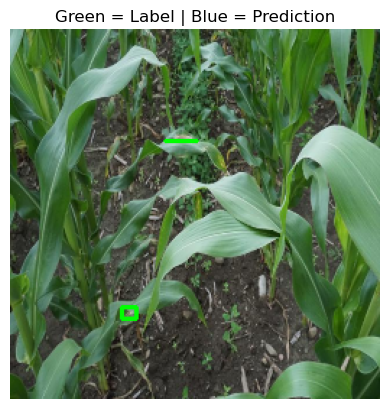

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


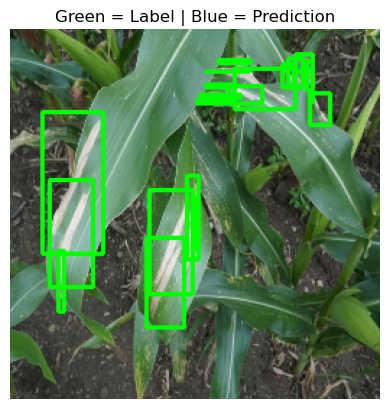

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


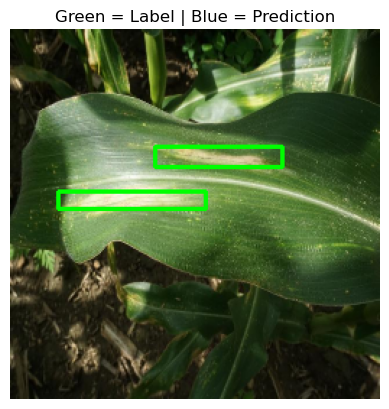

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


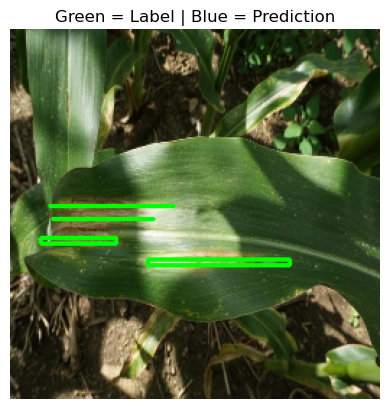

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


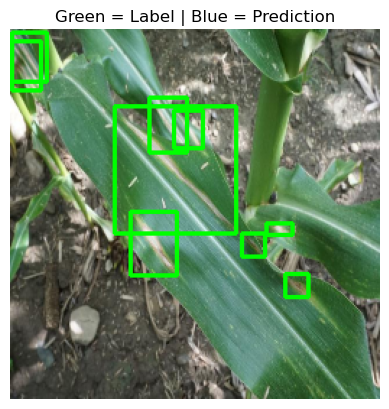

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


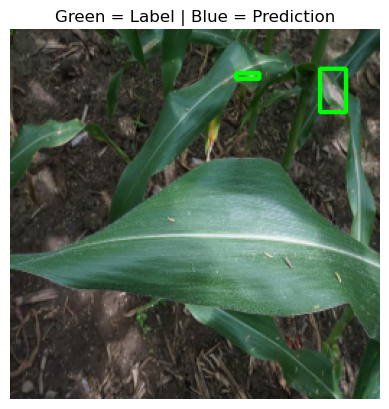

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


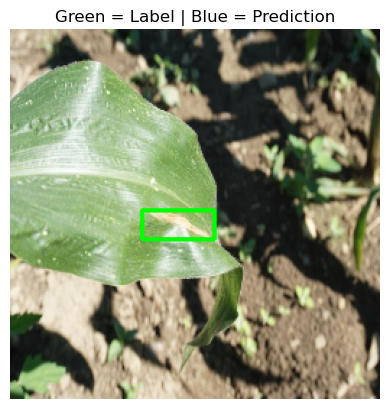

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


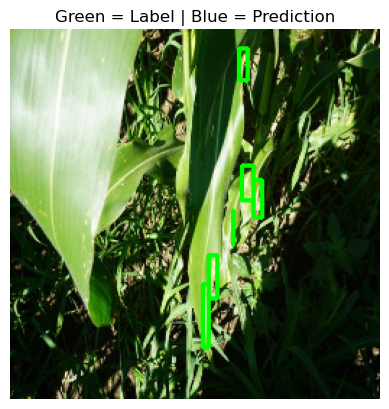

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


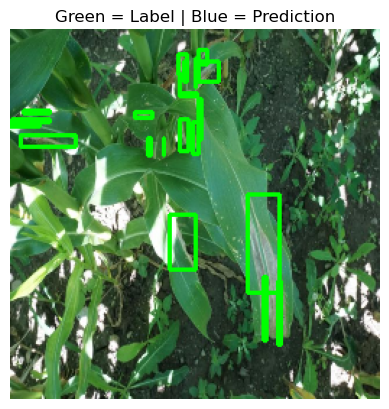

In [15]:
for i in range(10):
    image = x_val[i+10]
    true = y_val[i+10]
    pred = model.predict(image[np.newaxis, ...])[0]

    img = draw_boxes(image, true, pred)

    # Option 1: show in notebook
    plt.imshow(img)
    plt.axis('off')
    plt.title("Green = Label | Blue = Prediction")
    plt.show()

    # Option 2: log to wandb
    wandb.log({f"prediction_{i}": wandb.Image(img)})
